In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mrmr

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from sklearn.decomposition import PCA
from sklearn.tree import plot_tree
from sklearn.metrics import (
    accuracy_score, roc_auc_score,precision_score, f1_score, mean_squared_error,confusion_matrix,ConfusionMatrixDisplay
)


from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split, cross_validate, KFold, GridSearchCV
)
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from mrmr import mrmr_classif

In [61]:
df = pd.read_csv("Data/shopping.csv")

In [62]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [63]:
#Convert to categorical type variable
df["VisitorType"] = df["VisitorType"].astype("category")

In [64]:
df_work = df[["Informational_Duration","ExitRates","BounceRates","ProductRelated_Duration","PageValues","SpecialDay","VisitorType","Revenue"]]

In [65]:
#One hot encoding
df_work = pd.get_dummies(df_work)

In [66]:
X = df_work.drop(columns = "Revenue")
y = df_work["Revenue"]

#SMOTE
over = SMOTE(sampling_strategy=0.4)
#Undersampling on negative classes
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

#Data sampled as specified
X, y = pipeline.fit_resample(X, y)

In [72]:
#Calculating feature importances using trees
model = RandomForestClassifier(max_depth = 3)
model.fit(X,y)
model.predict(X)

array([False, False, False, ...,  True,  True,  True])

In [77]:
#Create dataframe containing both 
features = model.feature_names_in_
importances = model.feature_importances_
df_features = pd.DataFrame({
    "Feature" : features,
    "Importance" : importances
})

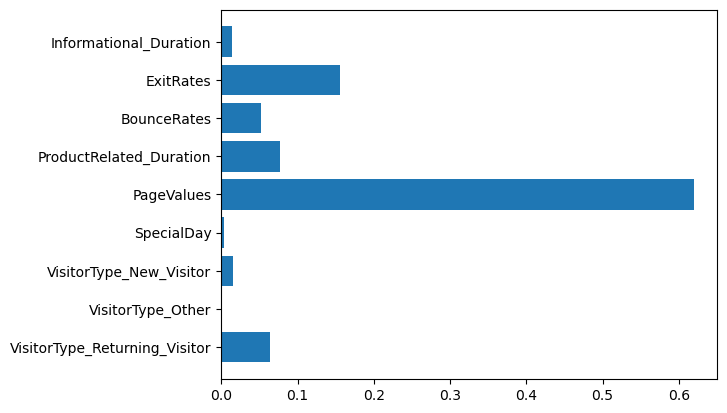

In [85]:
#make a bar plot
fig, ax = plt.subplots()
ax.barh(df_features["Feature"],df_features["Importance"], align='center')
ax.invert_yaxis()  # labels read top-to-bottom

plt.show()

In [67]:
#Using mRMR algorithm on data
selected_features = mrmr_classif(X=X, y=y, K=5)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


In [68]:
selected_features

['PageValues',
 'ProductRelated_Duration',
 'ExitRates',
 'VisitorType_Returning_Visitor',
 'SpecialDay']

In [92]:
# Divide the data into a training set and a test set.
#X_train uses the predictors output by the mRMR algorithm
X_train, X_test, y_train, y_test = train_test_split(
    X[["PageValues","ProductRelated_Duration","ExitRates","VisitorType_Returning_Visitor","SpecialDay"]],
    y,
    test_size=0.5,
    random_state=42
)

In [98]:
#Intial metrics arrays
Accuracies = []
F1_scores = []
Precision_scores = []

In [99]:
#KNN
model = KNeighborsClassifier()
#Scaling data
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)
#Perform PCA for 3 components
pca = PCA(3)
params = range(1,25)
pipe = Pipeline(
    steps = [
        ("scaler",scaler),
        ("pca",pca),
        ("KNN",model)
    ])

param_grid = {'KNN__n_neighbors' : params}

# Perform 20 fold cv. Use the f1 score to cross-validate.
cv = KFold(n_splits=20, shuffle=True)

# Set up a grid search.
grid = GridSearchCV(
    pipe, param_grid, cv=cv, scoring = "f1"
)

# Train the method.
grid.fit(X_train, y_train)


model = grid.best_estimator_
test_pred = model.predict(X_test)
accuracy_test_KNN = accuracy_score(test_pred,y_test)
f1_test_KNN = f1_score(test_pred,y_test)
precision_test_KNN = precision_score(test_pred,y_test)
print(f"testing accuracy : {accuracy_test_KNN}")
print(f"f1 testing score : {f1_test_KNN}")
print(f"testing precision : {precision_test_KNN}")
Accuracies.append(accuracy_test_KNN)
F1_scores.append(f1_test_KNN)
Precision_scores.append(precision_test_KNN)

testing accuracy : 0.8458093410108766
f1 testing score : 0.7576671694318754
testing precision : 0.732620320855615


In [100]:
#GradientBoosting with 10000 estimators and trees have max depth of 3
model = GradientBoostingClassifier(
    n_estimators=10000,
    learning_rate=0.0005,
    max_depth=3,
    random_state=1337
)
model.fit(X_train,y_train)


test_pred = model.predict(X_test)
accuracy_test_GB = accuracy_score(test_pred,y_test)
f1_test_GB = f1_score(test_pred,y_test)
precision_test_GB = precision_score(test_pred,y_test)
print(f"testing accuracy : {accuracy_test_GB}")
print(f"f1 testing score : {f1_test_GB}")
print(f"testing precision : {precision_test_GB}")

Accuracies.append(accuracy_test_GB)
F1_scores.append(f1_test_GB)
Precision_scores.append(precision_test_GB)

testing accuracy : 0.8742802303262955
f1 testing score : 0.8161833489242282
testing precision : 0.8483228001944579


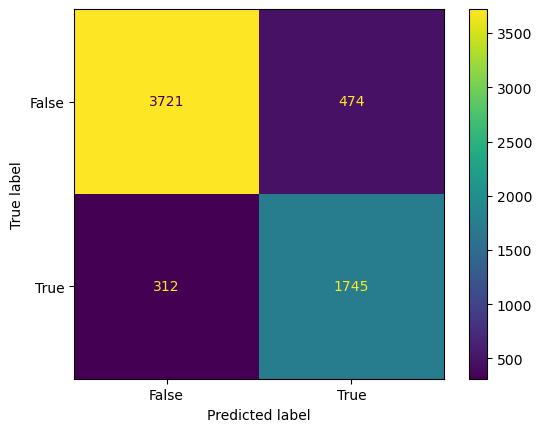

In [104]:
#Confusion matrix for Gradient Boosting
ConfusionMatrixDisplay.from_predictions(y_test, test_pred)

In [101]:
# Bagged classification trees.
# Determine the number of predictors.
nr_predictors = X_train.shape[1]

# Specify the model.
model = BaggingClassifier(estimator = RandomForestClassifier(), max_features = nr_predictors)

# Train the model.
model.fit(X_train, y_train)

# Determine performance on the training set.
y_train_pred = model.predict(X_train)
acc_train = accuracy_score(y_train, y_train_pred)

# Determine performance on the test set.
y_test_pred = model.predict(X_test)
acc_test_bag = accuracy_score(y_test, y_test_pred)
f1_test_bag = f1_score(test_pred,y_test)
prec_test_bag = precision_score(y_test,y_test_pred)


# Print the performance measures.
print(f"Test accuracy:     {acc_test_bag}")
print(f"Testing f1: {f1_test_bag}")
print(f"Test precision:     {prec_test_bag}")


Accuracies.append(acc_test_bag)
F1_scores.append(f1_test_bag)
Precision_scores.append(prec_test_bag)

Test accuracy:     0.8774792066538708
Testing f1: 0.8161833489242282
Test precision:     0.7965089572806615


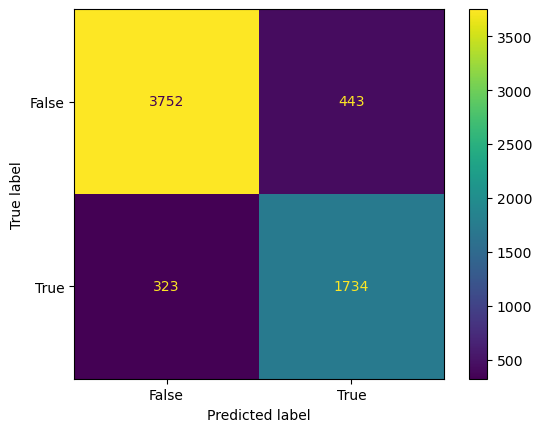

In [102]:
#Confusion Matrix for Bagging
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

In [127]:
#Logistic Regression 

model = LogisticRegression()

# Train the model.
model.fit(X_train, y_train)

# Determine performance on the training set.
y_train_pred = model.predict(X_train)
acc_train = accuracy_score(y_train, y_train_pred)

# Determine performance on the test set.
y_test_pred = model.predict(X_test)
acc_test_log = accuracy_score(y_test, y_test_pred)
f1_test_log = f1_score(test_pred,y_test)
prec_test_log = precision_score(y_test,y_test_pred)


# Print the performance measures.
print(f"Test accuracy:     {acc_test_log}")
print(f"Testing f1: {f1_test_log}")
print(f"Test precision:     {prec_test_log}")


Accuracies.append(acc_test_log)
F1_scores.append(f1_test_log)
Precision_scores.append(prec_test_log)

Test accuracy:     0.8267754318618042
Testing f1: 0.5969418960244649
Test precision:     0.8259705488621151


In [106]:
# SVM with radial Kernel  

model = SVC(kernel = "rbf")

parameters = range(1,10)

#Cost parameter with range 1 to 10 
param_grid = {'C': parameters}


# Perform 15 - fold CV. Use the f1 to cross-validate.
cv = KFold(n_splits= 15, shuffle=True)

# Set up a grid search.
grid = GridSearchCV(
    model, param_grid, cv=cv, scoring="f1"
)

# Train the method.
grid.fit(X_train,y_train)

model = grid.best_estimator_

model.fit(X_train,y_train)

train_pred = model.predict(X_train)

test_pred = model.predict(X_test)


testing_accuracy_SVM = accuracy_score(test_pred,y_test)

testing_F1_SVM = accuracy_score(train_pred,y_train)

testing_precision_SVM = precision_score(test_pred,y_test)

print(f"test accuracy : {testing_accuracy_SVM}")

print(f"test F1 : {testing_F1_SVM}")

print(f"test precision : {testing_precision_SVM}")


Accuracies.append(testing_accuracy_SVM)
F1_scores.append(testing_F1_SVM)
Precision_scores.append(testing_precision_SVM)

test accuracy : 0.7891874600127959
test F1 : 0.7879078694817658
test precision : 0.4744773942634905


In [128]:
Names = ["KNN","Gradient Boosted Trees", "Bagging Trees Random Forest","SVM - Radial","LogisticRegression"]
df_results = pd.DataFrame({
    "Model" : Names,
    "Precision" : Precision_scores,
    "Accuracy" : Accuracies,
    "F1" : F1_scores
})

In [129]:
print(df_results)

                         Model  Precision  Accuracy        F1
0                          KNN   0.732620  0.845809  0.757667
1       Gradient Boosted Trees   0.848323  0.874280  0.816183
2  Bagging Trees Random Forest   0.796509  0.877479  0.816183
3                 SVM - Radial   0.474477  0.789187  0.787908
4           LogisticRegression   0.825971  0.826775  0.596942
